In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

# Introduction

## Theory
The following part is based on the put-call parity:
\begin{equation}
C_t - P_t = S_t - K * B(t,T)
\end{equation}

We can reformulate the put-call parity as the following:
\begin{equation}
IV_t^C = IV_t^P
\end{equation} 

We define the deviation from put_call parity (DPCP) as:
\begin{equation}
DPCP_t = IV_t^P - IV_t^C
\end{equation}

We can expect this has a mean-reversion pattern, and can be used to predict the change in implied volatility.

## Modeling IVS using DPCP

We first model the IV of contract j (both call and put) at time t as a function of moneyness and maturity:
\begin{equation}
IV_{j,t} = f(M_{j,t}, \tau_{j,t}|\beta_{t}) + \epsilon_{j,t}
\end{equation}

We then have the DPCP of the ATM options:
\begin{equation}
DPCP_t = IV_{j,t}^P - IV_{j,t}^C = \epsilon_{j,t}^P - \epsilon_{j,t}^C
\end{equation}

We expect an equilibrium-correction relationship between $\epsilon_{j,t}^P$ and $\epsilon_{j,t}^C$, which use DPCP as mean drift:

\begin{equation}
\Delta\epsilon_{j,t}^P = q_1 * DPCP_{j, t-1} + \eta_{j,t}^P \\
\Delta\epsilon_{j,t}^C = q_2 * DPCP_{j, t-1} + \eta_{j,t}^C \\
\end{equation}

The proposed equilibrium-correction model for IVS is thus:
\begin{equation}
IV_{j,t}^P = f(M_{j,t}, \tau_{j,t}|\beta_{t}) + \epsilon_{j,t-1}^P + q_1 * DPCP_{j, t-1} + \eta_{j,t}^P \\
IV_{j,t}^C = f(M_{j,t}, \tau_{j,t}|\beta_{t}) + \epsilon_{j,t-1}^C + q_2 * DPCP_{j, t-1} + \eta_{j,t}^C \\
\end{equation}

## Forecasting the IVS

By fitting IVS to moneyness and maturity, we can get $\hat{\beta}_t$, and construct 1-day ahead forecasts by:
\begin{equation}
\hat{\beta}_{t+1} = \gamma + \sum_{k=0}^p\phi_k * \hat{\beta}_{t-k} + u_t
\end{equation}

This is where time-series models kick in.

The forecast computation of equilibrium-correction model is:
\begin{equation}
IV_{j,t+1}^P = f(M_{j,t+1}, \tau_{j,t+1}|\hat{\beta}_{t+1}) + \epsilon_{j,t}^P + q_1 * DPCP_{j, t} \\
IV_{j,t+1}^C = f(M_{j,t+1}, \tau_{j,t+1}|\hat{\beta}_{t+1}) + \epsilon_{j,t}^C + q_2 * DPCP_{j, t} \\
\end{equation}

# Data and Analysis
## Preparing data with features we want

- We first drop the entries that do not have IV values
- Then scale the maturity by a factor of 1/360 and subtract by 0.5, so the transformed maturity has a range of [-0.5, 0.5].
- We add a minus sign to the moneyness of put options, and scale the moneyness by a factor of 1/120.
- We create a feature called delta_moneyness, which equals to $\delta + 0.5$ for put options and $\delta - 0.5$ for call options. This feature has a range of [-0.5, 0.5]. This corresponds to the "moneyness feature" in the original paper.

In [2]:
raw = pd.read_csv("merged_options_data.csv", parse_dates = [2], index_col = 0)

clean = raw.loc[raw.iv!=0, ]
clean.reset_index(drop = True, inplace = True)
clean.loc[:, 'period'] /= 360
clean.loc[:, 'period'] -= 0.5
clean.loc[:, 'moneyness']/=120
clean.loc[:, 'delta_moneyness'] = clean.loc[:, 'delta']
clean.loc[clean.option_type == 'P', 'moneyness'] *= -1
clean.loc[clean.option_type == 'P', 'delta_moneyness'] += 0.5
clean.loc[clean.option_type == 'C', 'delta_moneyness'] -= 0.5

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


After cleaning the data, we've got 77257 entries from 755 days.

## Modeling IV on a given day as a function of moneyness and maturity
### Linear regression on $M_{j,t}$ ($\delta$ moneyness), $\tau_{j,t}$ (maturity), $M_{j,t}^2, M_{j,t}\tau_{j,t}, $

In [3]:
def IV_lr(data):
    X = data[['delta_moneyness','period']]
    X['mm'] = X['delta_moneyness'] **2
    X['mt'] = X['delta_moneyness'] * X['period']
    Y = data['iv']
    reg = LinearRegression().fit(X, Y)
    return [reg.coef_, reg.intercept_, Y-reg.predict(X)]

Fit a model for each day's data and getting residuals:

In [4]:
date_cut = np.where((np.diff(clean.date).astype(int)!=0))[0]+1
date_cut = np.append(date_cut, clean.shape[0])
date_cut = np.append([0], date_cut)
beta = np.zeros((len(date_cut)-1,5))
res = np.zeros(clean.shape[0])
for i in range(0, len(date_cut)-1):
    [beta[i, :4], beta[i, 4:], res[date_cut[i]:date_cut[i+1]]] = IV_lr(clean.iloc[date_cut[i]:date_cut[i+1]])

clean.loc[:,'res'] = res

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

After modeling IV, we can then calculate DPCP. Since we only have both put and call options of the same strike and maturity for at-the-money options, we will only keep the at-the-money options and do further analysis and prediction.

In [5]:
atm = clean.loc[clean.moneyness == 0, :]
atm.reset_index(drop = True, inplace = True)

In [6]:
# checking data format
for i in range(0, int(atm.shape[0]/2)):
    if atm.period[i*2] != atm.period[i*2+1] or atm.date[i*2] != atm.date[i*2+1]:
        print(i*2)
        
merge_atm = atm.loc[atm.option_type == 'P', :]
merge_atm.rename(index=str, columns={"delta": "delta_P", 
                                     "delta_moneyness": "delta_moneyness_P",
                                    "res": "res_P",
                                    "iv": "iv_P"}, 
                 inplace = True)
merge_atm.reset_index(drop = True, inplace = True)
merge_atm.drop(columns=['moneyness', 'option_type'], inplace = True)
tmp_C_df = atm.loc[atm.option_type == 'C', 
                                   ['delta', 'iv', 'delta_moneyness','res']]
tmp_C_df.reset_index(drop = True, inplace = True)
merge_atm = pd.concat([merge_atm, tmp_C_df], axis = 1)

merge_atm.rename(index=str, columns={"delta": "delta_C", 
                                     "delta_moneyness": "delta_moneyness_C",
                                    "res": "res_C",
                                    "iv": "iv_C"},
                 inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
merge_atm.loc[:,'DPCP'] = merge_atm.iv_P.values - merge_atm.iv_C.values
merge_atm.loc[:,'delta_res_P'] = merge_atm.res_P.values
merge_atm.loc[0:1,'delta_res_P'] = 0
merge_atm.loc[1:,'delta_res_P'] = np.diff(merge_atm.res_P.values)
merge_atm.loc[:,'delta_res_C'] = merge_atm.res_C.values
merge_atm.loc[0:1,'delta_res_C'] = 0
merge_atm.loc[1:,'delta_res_C'] = np.diff(merge_atm.res_C.values)

## Modeling change in $\epsilon_{j,t}$ by DPCP

Here our model is:
\begin{equation}
\Delta\epsilon_{j,t}^P = q_1 * DPCP_{j, t-1} + \eta_{j,t}^P \\
\Delta\epsilon_{j,t}^C = q_2 * DPCP_{j, t-1} + \eta_{j,t}^C \\
\end{equation}

Since $q_1$ and $q_2$ here have no time subscript, we need to split the time series into training set and testing set.

In [8]:
training = merge_atm.iloc[:3001, :]
testing = merge_atm.iloc[3001:4531, :]

X = training.DPCP[1:].values.reshape(-1, 1)
Y_P = training.res_P[:-1].values
Y_C = training.res_C[:-1].values
reg_P = LinearRegression().fit(X, Y_P)
reg_C = LinearRegression().fit(X, Y_C)

## Forecasting the IVS

### Constructing 1-day ahead forecast of $\hat{\beta}$
By fitting IVS to moneyness and maturity, we can get $\hat{\beta}_t$, and construct 1-day ahead forecasts by:
\begin{equation}
t
\end{equation}

Here we use VAR to model and forecast  $\hat{\beta}$.

For lag order selection, we use AIC based lag order selection in VAR, and limit maximum lag to be 5.

In [9]:
train_ind = 500
var_model = VAR(beta[:train_ind, :])
var_model_fit = var_model.fit(maxlags = 5, ic = 'aic')

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, May, 2019
Time:                     11:24:07
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -40.8639
Nobs:                     495.000    HQIC:                  -41.5346
Log likelihood:           7005.23    FPE:                5.93884e-19
AIC:                     -41.9681    Det(Omega_mle):     4.59768e-19
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.003433         0.007757            0.443           0.658
L1.y1         0.399965         0.061611            6.492           0.000
L1.y2        -0.109152         0.050609           -2.157           0.031
L1.y3        -0.003447

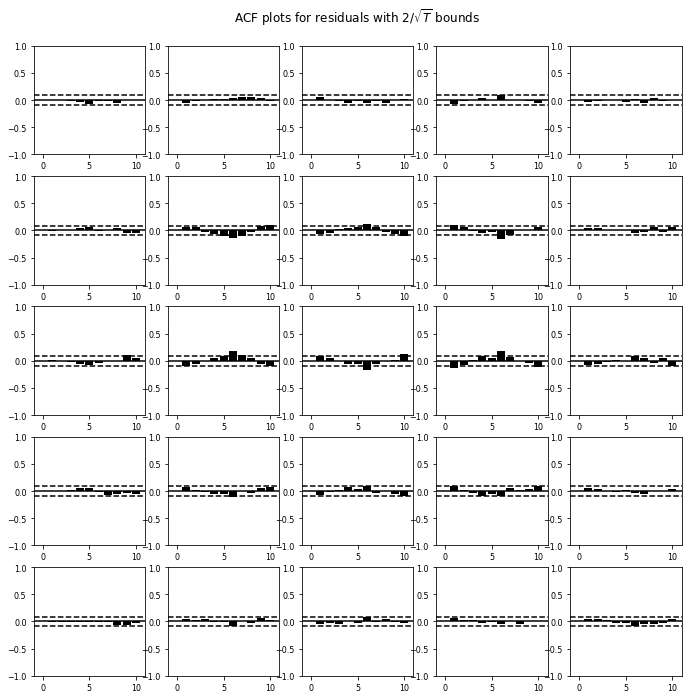

In [10]:
display(var_model_fit.summary())
var_model_fit.plot_acorr()

lag = 5

Next we forecast 1-day ahead $\hat{\beta}$ with each day's beta updated at the end of the day.

In [11]:
pred_beta = np.zeros(beta[train_ind:, ].shape)
for i in range(0, pred_beta.shape[0]):
    pred_beta[i, :] = var_model_fit.forecast(beta[train_ind-lag+i : train_ind+i], 1)

### Forecast using equilibrium-correction model

Next we construct forecast based on equilibrium-correction model:
\begin{equation}
IV_{j,t+1}^P = f(M_{j,t+1}, \tau_{j,t+1}|\hat{\beta}_{t+1}) + \epsilon_{j,t}^P + q_1 * DPCP_{j, t} \\
IV_{j,t+1}^C = f(M_{j,t+1}, \tau_{j,t+1}|\hat{\beta}_{t+1}) + \epsilon_{j,t}^C + q_2 * DPCP_{j, t} \\
\end{equation}

Parameters come from our estimation above.

In [12]:
iv_C_pred = np.zeros(testing.shape[0])
iv_P_pred = np.zeros(testing.shape[0])
date_cnt = 0

def lr_fit(coef, data):
    X = np.array([[data.delta_moneyness_P, data.period, 
                    data.delta_moneyness_P**2, 
                    data.delta_moneyness_P * data.period, 1],
             [data.delta_moneyness_C, data.period, 
                    data.delta_moneyness_C**2,
                    data.delta_moneyness_C * data.period, 1]])
    return [np.matmul(X, coef)[0], np.matmul(X, coef)[1]]

# skipping the first day in testing set
# date_cnt: keeping track of the number of days elapsed from the end of training set
# date_cnt corresponds to the index of beta
for i in range(6, testing.shape[0]):
    if testing.date[i] != testing.date[i-1]:
        date_cnt += 1
    
    [f_P, f_C] = lr_fit(pred_beta[date_cnt, :], testing.iloc[i,:])
    iv_P_pred[i] = f_P + testing.delta_res_P.iloc[i-6] + \
                        reg_P.predict(testing.DPCP.iloc[i-6].reshape(-1,1))
    iv_C_pred[i] = f_C + testing.delta_res_C.iloc[i-6] + \
                        reg_C.predict(testing.DPCP.iloc[i-6].reshape(-1,1))
        

### Forecasting outcome

In [14]:
print("MSE of out-of-sample IV for put options:",
      mean_squared_error(testing.iv_P.iloc[6:].values, iv_P_pred[6:]))
print("MSE of out-of-sample IV for call options:",
      mean_squared_error(testing.iv_C.iloc[6:].values, iv_C_pred[6:]))   

np.mean([mean_squared_error(testing.iv_P.iloc[6:].values, iv_P_pred[6:]),
       mean_squared_error(testing.iv_C.iloc[6:].values, iv_C_pred[6:])])

MSE of out-of-sample IV for put options: 0.0005412103365944277
MSE of out-of-sample IV for call options: 0.0007085071202696841


0.0006248587284320558

### Plotting the results

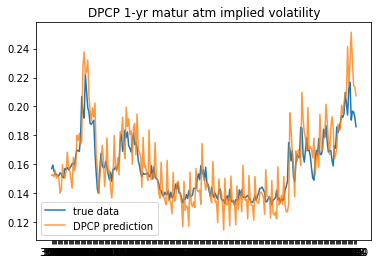

In [15]:
plt.plot(testing.loc[testing.period==0.5, 'iv_C'].iloc[1:], label = 'true data')
plt.plot(iv_C_pred[testing.period==0.5][1:], label = 'DPCP prediction', alpha = 0.8)
plt.legend()
plt.title('DPCP 1-yr matur atm implied volatility')
#plt.show()
plt.savefig('DPCP.jpg')